This notebook shows how to trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.   In our POC, there are 68 classes ofL1 and  318 classes of L2, so it is much complex than the notebook , but we can run POC with the same workflow as the notebook. 

This notebook uses the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.

IMDb lets users rate movies on a scale from 1 to 10, but the dataset only has positive and negative reviews. 

- negative review : score≤4
- positive review : score≥7

## Text Classification Workflow

Here is a standard workflow of text classification workflow. 

![Topic classification](images/text_classfication_workflow.png)

In order to simplify the steps, they can be splitted to two stages.

- Data Preparation 
  - Gather  Data: collect enough and good quality data.
  - Explore Data: 
  - Prepare Data:
- Model Construction
  - Build, Train & Evaluate Model
  - Tune Hyper-Parameters
  - Deploy Model

## Gather Data

Before starting, let's import the packages that we will use.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf

from collections import Counter
from scipy import stats
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

base_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/code'
sys.path.append(base_path)

from text_classification import set_gpu_memory, lr_schedule, ngram_vectorize, sequence_vectorize
from text_classification import plot_distribution, plot_length_distribution, plot_frequency_distribution
from text_classification import DictToObject, TextClassificationHelper
from text_classification import SimpleTextDataset, SequenceTextDataset

# 代码自动重新加载
%load_ext autoreload
%autoreload 2


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

In [3]:
set_gpu_memory(1024)
model_results={}

set max gpu memory to 1024


In [4]:
params = {
    'dataset_name': 'imdb',
    'classes': ['Negative', 'Positive'],
    'validation_percent': 0.0,     
    'batch_size': 32,    
    'max_features': 20000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'restore_best_checkpoint':True,
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':20},
        'rnn':{'dropout':0.3, 'embedding_dim':128, 'units':128, 'epochs':5},
        'sepcnn':{'dropout':0.3, 'epochs': 20},
    }
}

params = DictToObject(params)

### Download data 

Let's download and extract IMDB dataset.

In [5]:
dataset_dir =  os.path.join(os.path.expanduser('~'), '.keras/datasets/aclImdb') 
if not os.path.exists(dataset_dir):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True)
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    print(dataset_dir)

![image-20201217095446441](images/image-20201217095446441.png)

Explore the directory structure.

![image-20201104115404253](images/image-20201104115404253.png)

There are 2 folders which have the data.

- train: train data
- test: test data

### View data

Let's count how many positive and negative comments.

In [6]:
def get_files(base_dir):
    pos_dir = os.path.join(base_dir, 'pos')
    pos_files = os.listdir(pos_dir)
    pos_files = [os.path.join(pos_dir, file_name) for file_name in pos_files]
    
    neg_dir = os.path.join(base_dir, 'neg')
    neg_files = os.listdir(neg_dir)
    neg_files = [os.path.join(neg_dir, file_name) for file_name in neg_files]    

    return pos_files, neg_files

train_pos_files, train_neg_files = get_files(os.path.join(dataset_dir, 'train'))
test_pos_files, test_files = get_files(os.path.join(dataset_dir, 'test'))
    
print('train dataset: {} positive reviews, {} negative reviews'.format(len(train_pos_files), len(train_neg_files)))
print('test dataset: {} positive reviews, {} negative reviews'.format(len(test_pos_files), len(test_files)))

train dataset: 12500 positive reviews, 12500 negative reviews
test dataset: 12500 positive reviews, 12500 negative reviews


![image-20201217115036617](images/image-20201217115036617.png)

In [7]:
for file_path in train_pos_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...')  

------------------------------/root/.keras/datasets/aclImdb/train/pos/127_7.txt------------------------------
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.
------------------------------/root/.keras/datasets/aclImdb/train/pos/126_10.txt------------------------------
Zentropa is the most original movie I've seen in y

![image-20201217111649607](images/image-20201217111649607.png)

Below are some negative reviews.

In [8]:
for file_path in train_neg_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...') 

------------------------------/root/.keras/datasets/aclImdb/train/neg/127_4.txt------------------------------
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher ...
------------------------------/root/.keras/datasets/aclImdb/train/neg/126_1.txt------

![image-20201217100213645](images/image-20201217100213645.png)

Below are some positive reviews.

## Explore Data

Let's explore the data further. Understanding the characteristics of your data beforehand will enable you to build a better model. 

### Basic Information

First, we load the entire dataset.

In [9]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    print(indexs)
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    

def load_imdb_sentiment_analysis_dataset(imdb_data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

(train_texts, train_labels), (test_texts, test_labels) = load_imdb_sentiment_analysis_dataset(dataset_dir)


train_texts, train_labels = get_samples(train_texts, train_labels, rate=0.1)
test_texts, test_labels = get_samples(test_texts, test_labels, rate=0.1)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

[    0     1     2 ... 24997 24998 24999]
[    0     1     2 ... 24997 24998 24999]
train_texts.length=2500, train_labels.shape=(2500,)
test_texts.length=2500, test_labels.shape=(2500,)


![image-20201217122349480](images/image-20201217122349480.png)

### Classes Distribution

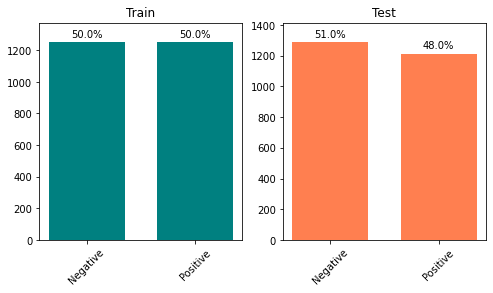

In [10]:
plot_distribution(train_labels, test_labels, params.classes)

![image-20201217123826241](images/image-20201217123826241.png)

### Sample Length Distribution

Check if the sample length in train dataset is similar as that in test dataset.

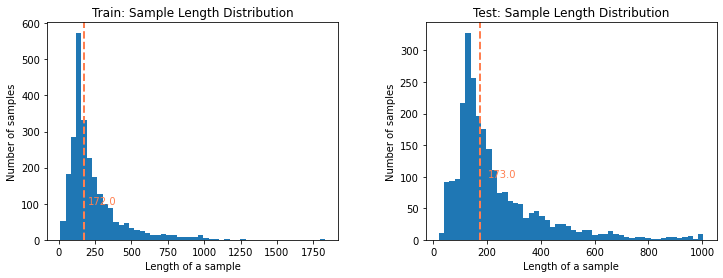

train：mean=234.37 variance=32384.80
test：mean=229.21 variance=27737.68


In [11]:


    
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))

In [12]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,294,1189,451,240,139,75,50,22,40,2500
train,299,1180,465,227,120,74,40,36,59,2500
合计,593,2369,916,467,259,149,90,58,99,5000


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,296.5,1184.5,458.0,233.5,129.5,74.5,45.0,29.0,49.5,2500.0
train,296.5,1184.5,458.0,233.5,129.5,74.5,45.0,29.0,49.5,2500.0
合计,593.0,2369.0,916.0,467.0,259.0,149.0,90.0,58.0,99.0,5000.0


In [13]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 10.189628231119991
critical_value = 15.50731305586545
p_value = 0.25196801601860175


![image-20201217131542940](images/image-20201217131542940.png)

### Frequency Distribution of Words

Check if the frequency distribution in train dataset is similar as that in test dataset.

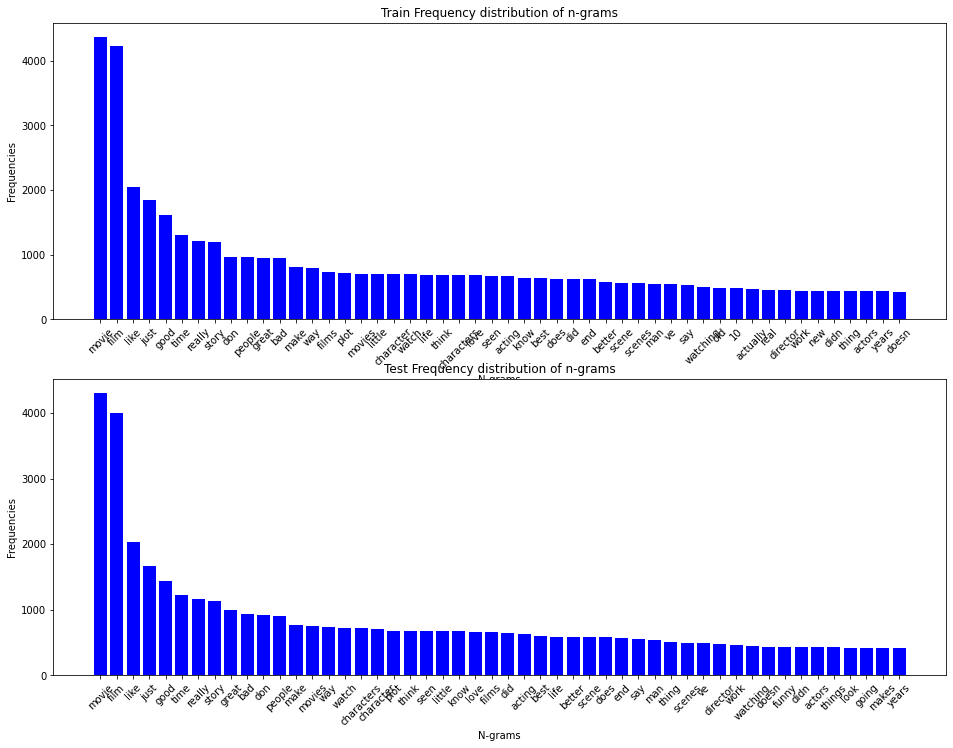

In [14]:
plot_frequency_distribution(train_texts, test_texts)

In [15]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 102035
Number of Vocabulary: 3690


![image-20201217142728260](images/image-20201217142728260.png)

## Prepare Data

Different models need to different data. So we need to choose a model first. 

### Choose a Model

Below is a flowchart from Google as a starting point to construct the first model. We can apply it in our POC. 

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
  a. Split the samples into word n-grams; convert the n-grams into vectors.
  b. Score the importance of the vectors and then select the top 20K using the scores.
    c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
     a. Split the samples into words; select the top 20K words based on their frequency.
    b. Convert the samples into word sequence vectors.
    c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [16]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 14.5


![image-20201217144321430](images/image-20201217144321430.png)

Though the ratio is leas than 1500, we still use RNN as the following model. Because RNN and its extended models (such as Transformer, BERT) show much powerful performance than MLP for 5 years.  

In real project, we will build MLP model first and then also build RNN model, and they are both the baselines of the performance.

### Load Data

First,  clean unused folder.

#### ngram

In [17]:
train_ngram, test_ngram, token_vectorizer = ngram_vectorize(train_texts, train_labels, test_texts, 
                                                            top_k=params.max_features)

print(train_ngram.shape, type(train_ngram), train_ngram.dtype)
print(test_ngram.shape, type(test_ngram), test_ngram.dtype)
print(train_ngram[0, 0:1000])


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1799: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


(2500, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
(2500, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 140)	0.044091742
  (0, 155)	0.09821745
  (0, 232)	0.09754925
  (0, 594)	0.05487043
  (0, 824)	0.048559967


In [18]:
ngram_data = SimpleTextDataset(params, train_ngram, train_labels, test_ngram, test_labels, train_texts, test_texts)

create train, validation and test dataset


#### sequence: Tokenizer

In [19]:
train_seq, test_seq, tokenizer_seq = sequence_vectorize(train_texts, test_texts, 
                                                        top_k=params.max_features,
                                                        max_sequence_length =params.sequence_length
                                                       )

print(train_seq.shape, type(train_seq), train_seq.dtype)
print(test_seq.shape, type(test_seq), test_seq.dtype)
print(test_seq[0][0:500])

(2500, 500) <class 'numpy.ndarray'> int32
(2500, 500) <class 'numpy.ndarray'> int32
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [21]:
sequence_data = SequenceTextDataset(params, train_seq, train_labels, test_seq, test_labels, 
                                    train_texts, test_texts, tokenizer_seq)

create train, validation and test dataset


#### sequence: TextVectorization

In [21]:
train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(train_dir))
remove_dir = os.path.join(train_dir, 'unsup')
if os.path.exists(remove_dir): shutil.rmtree(remove_dir)
print(os.listdir(train_dir))

['neg', 'pos', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']
['neg', 'pos', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']


![image-20201217152311389](images/image-20201217152311389.png)

Next, create train dataset, validation dataset and test datasets.

In [22]:
batch_size = params.batch_size
validation_split = params.validation_percent
seed = 42

if validation_split>0:
    raw_train_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size, 
        validation_split=validation_split,
        subset='training', 
        seed=seed)

    print('-'*100)
    raw_val_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size, 
        validation_split=validation_split,
        subset='validation', 
        seed=seed)    
    
else:
    print('-'*100)
    raw_train_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size)
    raw_val_seq_ds = None


print('-'*100)
raw_test_seq_ds = preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'test'), 
    batch_size=batch_size)

for text_batch, label_batch in raw_train_seq_ds.take(1):
    for i in range(3):
        print('-'*50, label_batch.numpy()[i], '-'*50)
        print(text_batch.numpy()[i])
        
print('-'*100)
print("Label 0 corresponds to", raw_train_seq_ds.class_names[0])
print("Label 1 corresponds to", raw_train_seq_ds.class_names[1])       

----------------------------------------------------------------------------------------------------
Found 25000 files belonging to 2 classes.
----------------------------------------------------------------------------------------------------
Found 25000 files belonging to 2 classes.
-------------------------------------------------- 1 --------------------------------------------------
b'"GEORGE LOPEZ," in my opinion, is an absolute ABC classic! I haven\'t seen every episode, but I still enjoy it. There are many episodes that I enjoyed. One of them was where Amy (Sandra Bullock) walked into a moving piece of machinery. If you want to know why, you\'ll have to have seen it for yourself. Before I wrap this up, I\'d like to say that everyone always gave a good performance, the production design was spectacular, the costumes were well-designed, and the writing was always very strong. In conclusion, even though new episodes can currently be seen, I strongly recommend you catch it just in c

![image-20201217152912385](images/image-20201217152912385.png)

### Token to Vector

The following function will remove the  punctuations or HTML elements to simplify the dataset.

Next, we will create a `TextVectorization` layer. we will use this layer to standardize, tokenize, and vectorize our data.

In [23]:
max_features = params.max_features
sequence_length = params.sequence_length

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_seq_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

print("7 ---> ",vectorize_layer.get_vocabulary()[7])
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

7 --->  is
1287 --->  lovely
 313 --->  idea
Vocabulary size: 20000


![image-20201217154849445](images/image-20201217154849445.png)

Next, we will convert the dataset from token to vector.

In [24]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_seq_ds = raw_train_seq_ds.map(vectorize_text)
if raw_val_seq_ds is not None:
    val_seq_ds = raw_val_seq_ds.map(vectorize_text)
else:
    val_seq_ds = None
test_seq_ds = raw_test_seq_ds.map(vectorize_text)

# cache data to improve the performance
train_seq_ds = train_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
if val_seq_ds is not None: 
    val_seq_ds = val_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_seq_ds = test_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 查看数据
vector_batch, label_batch = next(iter(train_seq_ds))
first_vector, first_label = vector_batch[0], label_batch[0]

print('Label：{}'.format(params.classes[first_label]))
print('-'*40, 'Vector', '-'*40)
print(first_vector.numpy())
print('-'*40, 'orginal review', '-'*40)
print(' '.join([vectorize_layer.get_vocabulary()[v] for v in first_vector]))

Label：Negative
---------------------------------------- Vector ----------------------------------------
[   51    10   209  5510     5    11    17    10   199    12     9   193
    26   989    18     9    76    30   214    26   160    73    10    13
   352    53   149  1154   942   185     2  1136    67    33   213   730
     6  2755    42   778   108   307   572     3     1    64   117     2
    94    34   773     6  1584    12   730    13   509     2    85  5765
   206   138   693   559     6     2   365    13  2298   160    18    32
     2   126    10    97   212  5577    48   370 19991     7   165     6
   573   364   450     2    17    10    38     4   922     5   275   711
   400     5   405     3   276   321    13    30   113  1475    60     7
   124    50    70    10    68   130    15     2    17   395     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0  

At last, let's check the data.

## Model

### MLP

In [26]:
def sparse_to_dense(value):
    if isinstance(value, tf.sparse.SparseTensor):
        return tf.sparse.to_dense(value)
    return value

def get_mlp(helper, dropout=None, name='mlp'):
    """Creates an instance of a multi-layer perceptron model"""
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    layer_count = helper.get_model_param(name, 'layer_count')
    units = helper.get_model_param(name, 'units')    
    
    input = layers.Input(shape=helper.data.input_shape)    
    x = tf.keras.layers.Lambda(sparse_to_dense)(input)
    if dropout>0: x = layers.Dropout(dropout)(x)
        
    for _ in range(layer_count):
        x = layers.Dense(units, activation='relu')(x)
        if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    
    model = Model(inputs=input, outputs=x, name=name)     
    helper.compile(model)   
    return model

helper = TextClassificationHelper(params, model_results=model_results, data=ngram_data)
model = get_mlp(helper)
model.summary()

model_params.mlp.dropout=0.6
model_params.mlp.layer_count=1
model_params.mlp.units=256
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/mlp/checkpoint
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
lambda (Lambda)              (None, 20000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5120256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)

2021-01-04 07:03:31,777: INFO: start training


model_params.mlp.epochs=20
use ModelCheckpoint(filepath=./checkpoints/imdb/mlp/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/20
79/79 [==============================] - 1s 9ms/step - loss: 0.6324 - accuracy: 0.7376 - val_loss: 0.5479 - val_accuracy: 0.8144
Epoch 2/20
79/79 [==============================] - 1s 7ms/step - loss: 0.3508 - accuracy: 0.9128 - val_loss: 0.3846 - val_accuracy: 0.8476
Epoch 3/20
79/79 [==============================] - 1s 7ms/step - loss: 0.1713 - accuracy: 0.9596 - val_loss: 0.3384 - val_accuracy: 0.8592
Epoch 4/20
79/79 [==============================] - 0s 6ms/step - loss: 0.1022 - accuracy: 0.9756 - val_loss: 0.3245 - val_accuracy: 0.8528
Epoch 5/20
79/79 [==============================] - 0s 6ms/step - loss: 0.0741 - accuracy: 0.9844 - val_loss: 0.3211 - val_accuracy: 0.8560
Epoch 6/20
79/79 [=======

2021-01-04 07:03:42,801: INFO: finish training [elapsed time: 11.02 seconds]


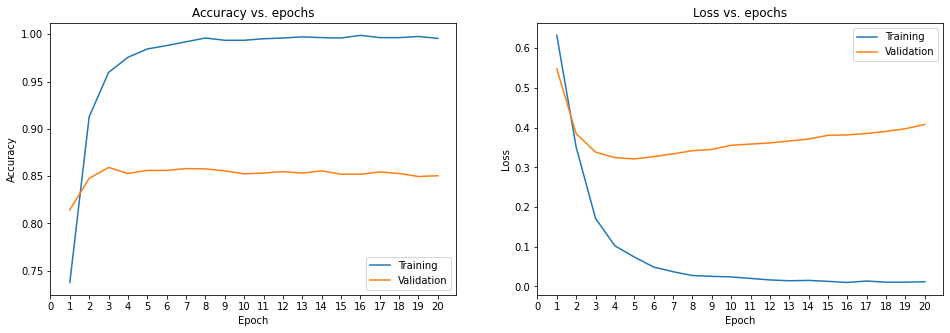

In [27]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
79/79 [==============================] - 0s 2ms/step - loss: 0.3384 - accuracy: 0.8592
Test loss:0.3384, Test Accuracy:85.92%
---------------------------------------- confusion matrix ----------------------------------------
79/79 [==============================] - 0s 2ms/step


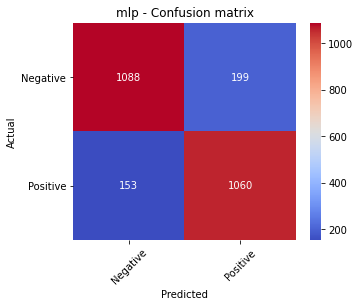

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.079445,0.9948,0.338354,0.8592,5120770,11.0


In [28]:
helper.model_summary(model, history=history)

### RNN 

In [29]:
def get_rnn(helper, name='rnn', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')    
    
    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.SimpleRNN(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_rnn(helper)
model.summary()

model_params.rnn.dropout=0.3
model_params.rnn.units=64
max_features=20000
model_params.rnn.embedding_dim=128
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/rnn/checkpoint
Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 128)          2560128   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 2,572,610
Trainable params: 2,572,610
Non-trainable params: 0
______

2021-01-04 07:03:44,665: INFO: start training


model_params.rnn.epochs=5
use ModelCheckpoint(filepath=./checkpoints/imdb/rnn/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
78/78 [==============================] - 32s 410ms/step - loss: 0.6886 - accuracy: 0.5733 - val_loss: 0.6517 - val_accuracy: 0.6260
Epoch 2/5
78/78 [==============================] - 32s 407ms/step - loss: 0.3250 - accuracy: 0.8958 - val_loss: 0.6051 - val_accuracy: 0.6772
Epoch 3/5
78/78 [==============================] - 32s 405ms/step - loss: 0.0609 - accuracy: 0.9896 - val_loss: 0.6720 - val_accuracy: 0.7028
Epoch 4/5
78/78 [==============================] - 32s 405ms/step - loss: 0.0119 - accuracy: 0.9996 - val_loss: 0.6693 - val_accuracy: 0.7176
Epoch 5/5
78/78 [==============================] - 31s 402ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.6923 - val_accuracy: 0.7436


2021-01-04 07:06:26,142: INFO: finish training [elapsed time: 161.48 seconds]


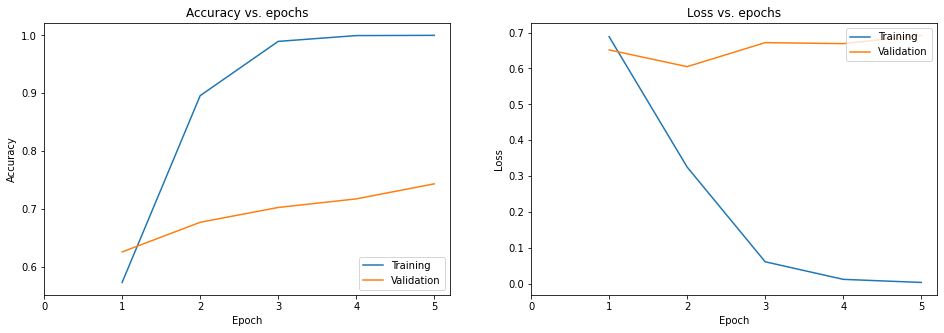

In [30]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
79/79 [==============================] - 6s 71ms/step - loss: 0.6923 - accuracy: 0.7436
Test loss:0.6923, Test Accuracy:74.36%
---------------------------------------- confusion matrix ----------------------------------------
79/79 [==============================] - 5s 69ms/step


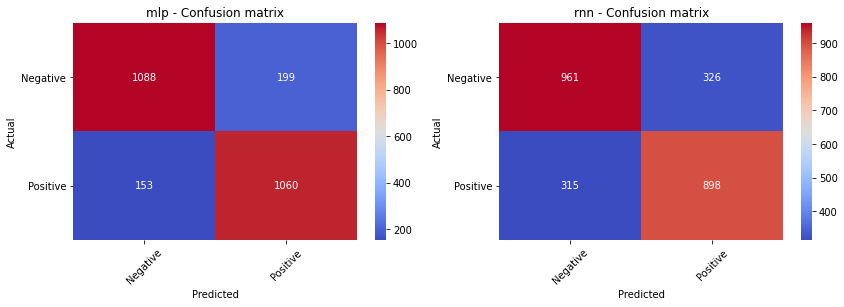

---------------------------------------- error analysis ----------------------------------------
79/79 [==============================] - 5s 69ms/step
........................................ Negative ........................................
Originally, the Spiders was planned as a four-part serial, and it shows. I dislike serials; they're typically ridiculous, convoluted and banal. This one is no exception. In the first part of the Spiders, 'The Golden Lake,' a rich adventurer thwarts the plans of a gang of criminals--the Spiders--to steal gold from Incas. A silly love triangle ensues, with some Cowboys and Indians action. The sensationalism and exotica of it didn't entertain me.<br /><br />One can legitimately trace themes from this two-part series to Lang's later, far superior work. And, the film-making is better than in other serials I've seen from this time, including 'Les Vampires' (1915). In the Spiders, the camera isn't as static, and this film is fast paced, thankfully. The ti

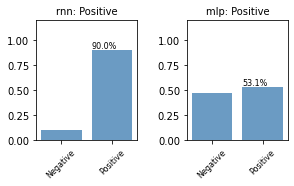

........................................ Positive ........................................
Definitely worth watching.<br /><br />Ten different directors each present a segment based on their favorite opera aria. You don't need to be an opera lover to watch this film. (Although, of course, if you hate opera, you're really going to have a bad time with this!)<br /><br />Not surprisingly the segments range from brilliant to only fair. Most of the fuss seems to be over Godard's contribution -- whether you think he's brilliant or pretentious, his segment won't change your mind.<br /><br />Some of the pieces have a clear narrative; others are more a montage of connected images.<br /><br />None of the pieces is more than 10 minutes or so; if you're not happy with what's on the screen, wait for the next segment, and think about how much culture you're soaking up.<br /><br />Keep your eyes open for performances by Buck Henry, Beverly D'Angelo, Elizabeth Hurley, Briget Fonda, Tilda Swinton, and 

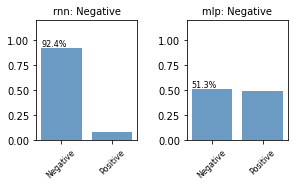

........................................ Positive ........................................
Its very tough to portray a Tagore novel along cinematographic lines.And if you forget an obscure production of 1967 then its the first time that chokher bali has been done on a grand scale. Overall the sets looked fantastic with the right touches for making a successful period drama.Prasenjit,so used to doing crass commercial stuff made a good effort.I saw the Bengali version and found that Aishwariya's voice was dubbed,which made her dialog delivery a bit poor. While the director did a good job portraying each of the characters with finesse,yet there was very little in the way of meaningful plot,probably a lack of the story itself.However the development of the characters including those with minor roles seem to be the strongest point.Its tough to make some Tagore stories into films,as only the visual parts seem to get realized.


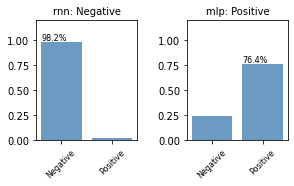

........................................ Positive ........................................
The lovely, yet lethal Alexandra (stunning statuesque blonde beauty Stacie Randall, who looks absolutely smashing in a tight black leather outfit) must find a magic amulet so her evil demonic master Faust can cross over into our dimension. It's up to fearless, rugged cop Jonathan Graves (likable Peter Liapis) to stop her. Meanwhile, two pitifully unfunny "comic relief" dwarf gnome creatures run amok in Los Angeles. Seasoned veteran schlock exploitation expert Jim Wynorski relates the supremely inane story at a brisk pace and takes none of this foolishness remotely seriously. The cast struggle gamely with the silly material: the adorable Barbara Alyn Woods as sassy, fetching police captain Kate, Raquel Krelle as tart, sexy hooker Jeanine, Bobby Di Cicco as Graves' bumbling, excitable partner Scotty, Peggy Trentini as alluring museum curator Monica, and Ace Mask as the jolly Dr. Rochelle. Mark Stev

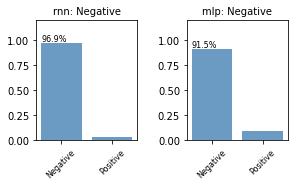

........................................ Negative ........................................
THE GOOD: The acting were great especially Terrence Howard and Thandie Newton. Terrence Howard should have been nominated for Best Supporting Actor instead of Matt Dillon.<br /><br />THE BAD: I'm a visible minority (non-white) and I have experienced some form of racism in my life. BUT despite my life experiences and the movie's subject matter, I would definitely NOT say that this movie is the best of the year, in fact, it's FAR from it. I have problems with this movie both from a moviegoer's perspective and from a visible minority's perspective. Some of my problems with this movie are:<br /><br />(1) Poor character development (or none at all). Just because we saw extremes in a character, for example, Matt Dillon being a racist cop and being a good caregiver to his ailing father, that does not mean in any way that the character is well-developed. Yes, I admit that in a big cast ensemble like in t

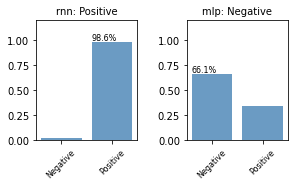

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.079445,0.9948,0.338354,0.8592,5120770,11.0
rnn,0.001546,1.0000,0.692347,0.7436,2572610,161.0


In [31]:
helper.model_summary(model, history=history)

### LSTM

In [32]:
def get_lstm(helper, name='rnn_lstm', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   

    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm(helper)
model.summary()


model_params.rnn_lstm.dropout=0.3
model_params.rnn_lstm.units=64
max_features=20000
model_params.rnn_lstm.embedding_dim=128
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/rnn_lstm/checkpoint
Model: "rnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 128)          2560128   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 2,609,666
Trainable params: 2,609,666
Non-t

2021-01-04 07:06:52,691: INFO: start training


model_params.rnn_lstm.epochs=5
use ModelCheckpoint(filepath=./checkpoints/imdb/rnn_lstm/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
78/78 [==============================] - 50s 641ms/step - loss: 0.6476 - accuracy: 0.6390 - val_loss: 0.5527 - val_accuracy: 0.7392
Epoch 2/5
78/78 [==============================] - 49s 625ms/step - loss: 0.2710 - accuracy: 0.9014 - val_loss: 0.4535 - val_accuracy: 0.8016
Epoch 3/5
78/78 [==============================] - 49s 625ms/step - loss: 0.0615 - accuracy: 0.9844 - val_loss: 0.4573 - val_accuracy: 0.8104
Epoch 4/5
78/78 [==============================] - 50s 635ms/step - loss: 0.0211 - accuracy: 0.9960 - val_loss: 0.6944 - val_accuracy: 0.8192
Epoch 5/5
78/78 [==============================] - 49s 624ms/step - loss: 0.0079 - accuracy: 0.9992 - val_loss: 0.9331 - val_accuracy: 0.7996


2021-01-04 07:11:04,150: INFO: finish training [elapsed time: 251.46 seconds]


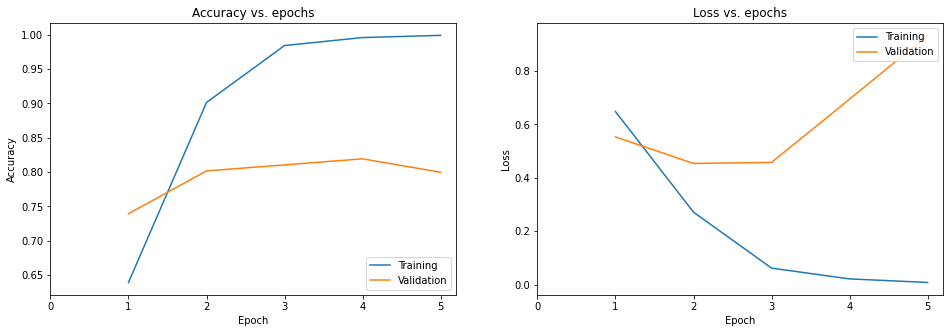

In [33]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
79/79 [==============================] - 9s 118ms/step - loss: 0.6944 - accuracy: 0.8192
Test loss:0.6944, Test Accuracy:81.92%
---------------------------------------- confusion matrix ----------------------------------------
79/79 [==============================] - 9s 117ms/step


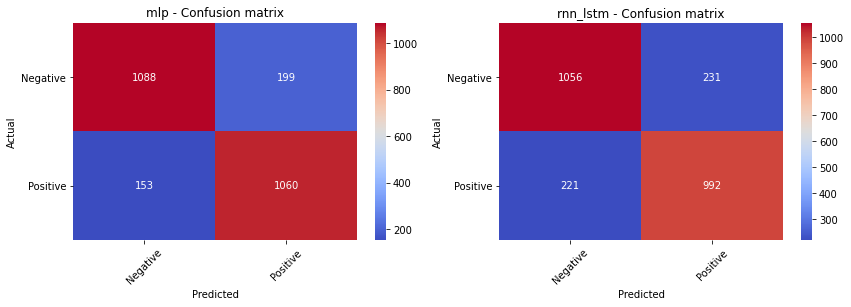

---------------------------------------- error analysis ----------------------------------------
79/79 [==============================] - 9s 117ms/step
........................................ Positive ........................................
I just returned from viewing this academy award-nominated doc, and I was thoroughly touched and interested in exploring the works of this fellow I'd never heard of before. Of course I'm someone who's captivated with beautiful architecture, so I realize others won't care.<br /><br />We can only imagine if there had been a couple more visionaries in Philadelphia back in the late 60's when Kahn's plans were a possibility, what a wonderful city center there would be. If you wonder whether you'll see more about the Bangladesh building at the beginning of the movie, be patient, for there it will provide the climax of the film at the end. <br /><br />His son's personal discoveries in the process of making this film are quite interesting, sometimes touchi

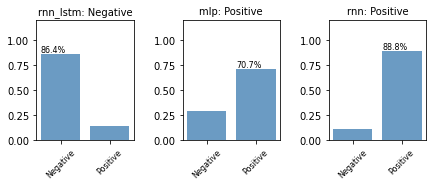

........................................ Negative ........................................
I've read all the complimentary posts on this muddled semi-noir and am puzzled at the high regard for what seems, in the cruel light of 2007, a very sloppy late-RKO assembly-line product. All that endless documentary footage of fish, waves, fish, waves has little to do with the central conflict and just pads the running time. The editing is downright careless: Scenes just end, and are followed by other scenes that have little to do with what preceded them. The dialog bears the stilted traces of the Odets origins: high-flown metaphors that never could have come from the limited imaginations of these workaday people. But what's really surprising is how horribly overacted the triangle is, on all sides. I love Stanwyck, but she snarls and contorts and lashes out wildly -- an undisciplined performance several notches below her standard. Douglas, overplaying at being lovable, then goes onto a would-be 

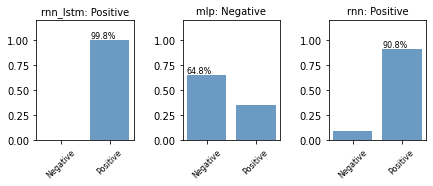

........................................ Negative ........................................
Low budget horror about an evil force. Hard to believe in this day and age, but way back when this stuff actually used to get theatrical release! These days this sort of thing would either go direct-to-video or straight to cable. Shouldn't be too hard to avoid this one; who's ever heard of it?


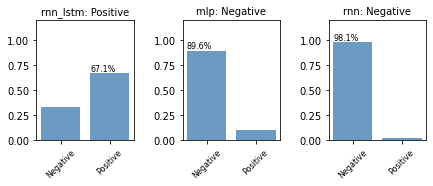

........................................ Positive ........................................
Along with In the Army!, this ranks as one of Pauly Shore's best movies, if there is such a thing. While the whole West Coast-meets- Midwest-culture-clash isn't anything new, this film proves to make the story a little more entertaining with the wild and unpredictable antics of a then fresh Shore. While the change in values probably would have gone in the other direction, the whole concept was rather entertaining. Not only was Shore's interaction with the family hilarious, it also had Carla Gugino and Tiffani- Amber Theissen (she'll always have the Amber in my book) in two ravishing and early roles. One of those films I have no problem watching when it is on TV.


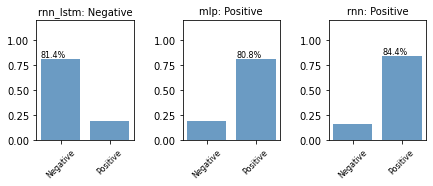

........................................ Negative ........................................
I am a fan of good historical fiction, and was thrilled at the thought that someone would take a well written book series and film it. Writing scripts is not like writing regular fiction, but when you have a book you are adapting, it would be nice to actually follow the plot line.<br /><br />The portrayals of the Vespasians (the actual Emperor, and his 2 sons Titus and Domitian) was horrid. They acted like a cookie cutter Caligula, and were the 'bad guys' in this adaptation. There was a scene with Titus dispensing justice as if he was Caligula (from the movie of the same name.) The way the Vespasianii are portrayed in the books mostly follow the reports of historians writing in that time period - they were fair, and sane, not tainted by the Imperial Claudian insanity.<br /><br />Helena (the love interest of Marcus Didius Falco) gives as her reason for divorcing Pertinax (one of the traitors refer

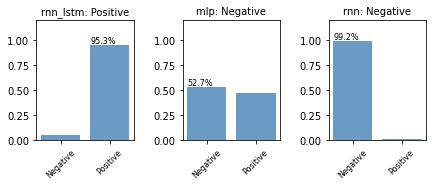

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.079445,0.9948,0.338354,0.8592,5120770,11.0
rnn_lstm,0.003936,0.9992,0.694391,0.8192,2609666,251.0
rnn,0.001546,1.0000,0.692347,0.7436,2572610,161.0


In [34]:
helper.model_summary(model, history=history)

### LSTM + Bidirectional

In [35]:
def get_lstm_bi(helper, name='rnn_lstm_bi', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   
    
    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.Bidirectional(layers.LSTM(units=units))(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm_bi(helper)
model.summary()

model_params.rnn_lstm_bidirectional.dropout=0.3
model_params.rnn_lstm_bidirectional.units=64
max_features=20000
model_params.rnn_lstm_bidirectional.embedding_dim=128
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/rnn_lstm_bidirectional/checkpoint
Model: "rnn_lstm_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 128)          2560128   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)               

2021-01-04 07:11:49,466: INFO: start training


model_params.rnn_lstm_bidirectional.epochs=5
use ModelCheckpoint(filepath=./checkpoints/imdb/rnn_lstm_bidirectional/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
78/78 [==============================] - 74s 955ms/step - loss: 0.6442 - accuracy: 0.6290 - val_loss: 0.5062 - val_accuracy: 0.7600
Epoch 2/5
78/78 [==============================] - 73s 939ms/step - loss: 0.3587 - accuracy: 0.8730 - val_loss: 0.4267 - val_accuracy: 0.8016
Epoch 3/5
78/78 [==============================] - 72s 926ms/step - loss: 0.0887 - accuracy: 0.9728 - val_loss: 0.5548 - val_accuracy: 0.7988
Epoch 4/5
78/78 [==============================] - 73s 933ms/step - loss: 0.0196 - accuracy: 0.9968 - val_loss: 0.4912 - val_accuracy: 0.8132
Epoch 5/5
78/78 [==============================] - 72s 927ms/step - loss: 0.0052 - accuracy: 0.9996 - val_loss: 0.6733 -

2021-01-04 07:18:03,950: INFO: finish training [elapsed time: 374.48 seconds]


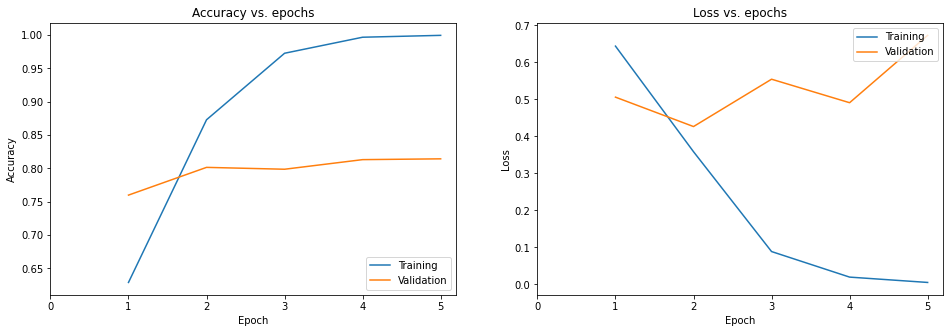

In [36]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
79/79 [==============================] - 15s 192ms/step - loss: 0.6733 - accuracy: 0.8144
Test loss:0.6733, Test Accuracy:81.44%
---------------------------------------- confusion matrix ----------------------------------------
79/79 [==============================] - 15s 188ms/step


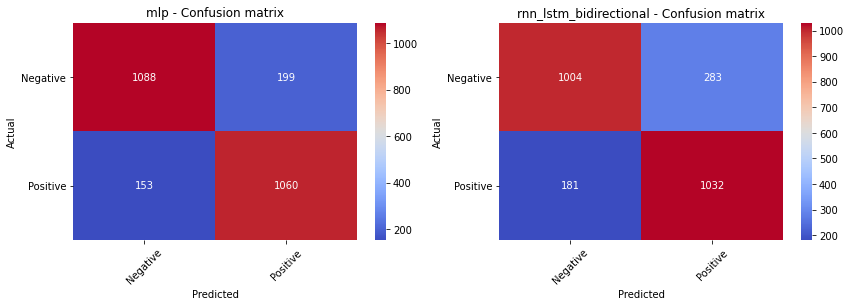

---------------------------------------- error analysis ----------------------------------------
79/79 [==============================] - 15s 191ms/step
........................................ Negative ........................................
"The Italian Job" is a caper movie done by the numbers. Riding on the back of every caper cliche, it rises to no particular heights and will be a movie footnote by about the end of the month.<br /><br />The biggest problem is that "The Italian Job" possesses no imagination at all. I've seen it all before and done better then. The acting is fine the cinematography is completely acceptable, but this film breaks absolutely no new ground.<br /><br />Let's tick off the cliches:<br /><br /> - "old-school" criminal father figure and his protege<br /><br /> - another gang member jealous of protege<br /><br /> - a double-cross<br /><br /> - only bad guys use guns while good-guy criminals don't have to<br /><br /> - good criminals always outwit the bad guy

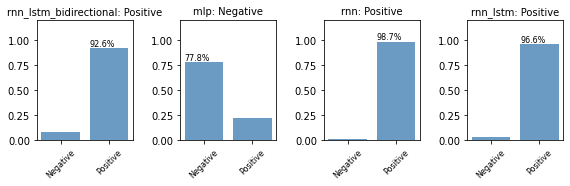

........................................ Negative ........................................
The Play Macbeth was written by William Shakespeare between the years of 1604 and 1606. Ever since then, many other versions of the play have been produced, including remakes completed in 1948, 1971, and 2006. Akira Kurosawa even directed a Japanese version of Macbeth in 1957 entitled, "Kumonosu jô." The play starts out with King Duncan hearing about the success of two of his generals, Macbeth and Banquo, in a recent battle with the Irish and the Norwegians. After a quick promotion from Duncan, Macbeth instantly gets an uncanny feeling for lust, greed, and power and does everything in his power to gain access to the crown: even if it includes murder.<br /><br />Geoffrey Wright tried creating his own version of the famous play in 2006 by setting it in the modern Melbourne underworld. Just imagine a lowly Macbeth slaying hundreds of soldiers with an AK-47 and rapping his own rendition of, "Low" at 

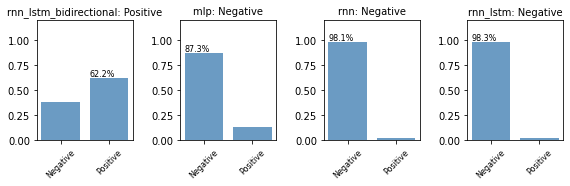

........................................ Positive ........................................
The curse of Monkey Island is a brilliant video game and its a stroke of genius from the video game designers at lucasarts to have created this sequel. All the characters are brilliant, the voice overs for the characters were realistic and funny. A lot of effort went into this game and it deserves the 10 i gave in the vote, keep up the good work lucasarts!


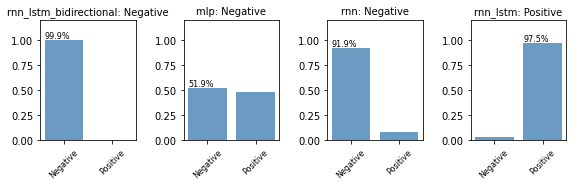

........................................ Negative ........................................
I like Christophe Lambert as an actor. He has played in several good movies (Highlander, Subway, Greystoke, ...). But I can't even think he has played in that movie. The story is nearly nothing, the special effects are very bad and the actors also. To resume the movie, I have only one thing to say : it's the first time that I go to watch a movie and want to leave after 10 minutes.


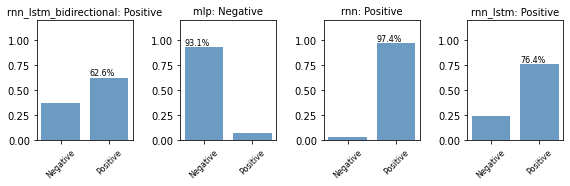

........................................ Negative ........................................
Opulent sets and sumptuous costumes well photographed by Theodor Sparkuhl, and a good (not great) performance by Jannings as Henry cannot overcome poor writing and static camera-work. Henny Porten chews the scenery as Anne.<br /><br />It's all very beautiful; but it's all surface and no depth. The melodramatic tale of a woman wronged made it a hit in America where the expressionistic "The Cabinet of Dr. Caligari" flopped in the same year (1920), proving that what is popular is not what endures. Lubitsch would be remembered for his lively comedies, not sterile spectacles like this.


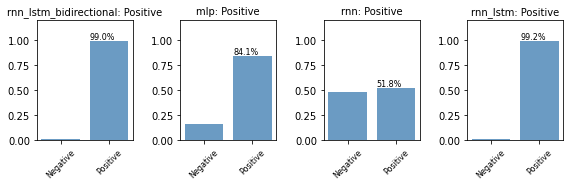

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.079445,0.9948,0.338354,0.8592,5120770,11.0
rnn_lstm,0.003936,0.9992,0.694391,0.8192,2609666,251.0
rnn_lstm_bidirectional,0.002074,0.9996,0.673339,0.8144,2659202,374.0
rnn,0.001546,1.0000,0.692347,0.7436,2572610,161.0


In [37]:
helper.model_summary(model, history=history)

### 2 Stacked LSTM

In [38]:
def get_lstm_stacked(helper, name='rnn_lstm_stacked', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   
    
    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm_stacked(helper)
model.summary()

model_params.rnn_lstm_stacked.dropout=0.3
model_params.rnn_lstm_stacked.units=64
max_features=20000
model_params.rnn_lstm_stacked.embedding_dim=128
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/rnn_lstm_stacked/checkpoint
Model: "rnn_lstm_stacked"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 128)          2560128   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 128)          98816     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________

2021-01-04 07:19:17,055: INFO: start training


model_params.rnn_lstm_stacked.epochs=5
use ModelCheckpoint(filepath=./checkpoints/imdb/rnn_lstm_stacked/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
78/78 [==============================] - 124s 2s/step - loss: 0.5960 - accuracy: 0.6691 - val_loss: 0.4608 - val_accuracy: 0.7884
Epoch 2/5
78/78 [==============================] - 120s 2s/step - loss: 0.1909 - accuracy: 0.9283 - val_loss: 0.4669 - val_accuracy: 0.8192
Epoch 3/5
78/78 [==============================] - 122s 2s/step - loss: 0.0393 - accuracy: 0.9884 - val_loss: 0.7456 - val_accuracy: 0.8144
Epoch 4/5
78/78 [==============================] - 121s 2s/step - loss: 0.0150 - accuracy: 0.9960 - val_loss: 0.9295 - val_accuracy: 0.8016
Epoch 5/5
78/78 [==============================] - 121s 2s/step - loss: 0.0122 - accuracy: 0.9964 - val_loss: 1.0393 - val_accuracy: 0.8048


2021-01-04 07:29:38,947: INFO: finish training [elapsed time: 621.89 seconds]


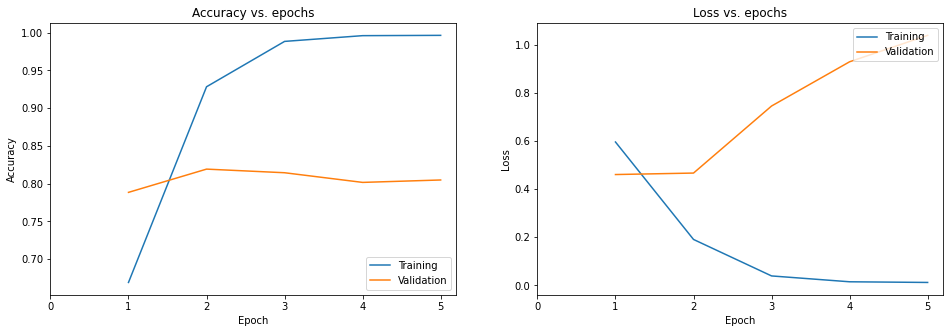

In [39]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
79/79 [==============================] - 24s 304ms/step - loss: 0.4669 - accuracy: 0.8192
Test loss:0.4669, Test Accuracy:81.92%
---------------------------------------- confusion matrix ----------------------------------------
79/79 [==============================] - 24s 306ms/step


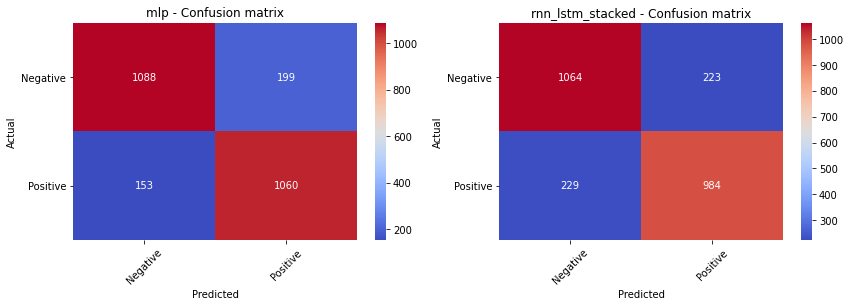

---------------------------------------- error analysis ----------------------------------------
79/79 [==============================] - 24s 308ms/step
........................................ Negative ........................................
The poet Carne disappears (didn´t he disappeared with Prévert?) and is followed by the judge Carne. The director wants to give his own vision of a youth that he doesn´t understand and he doesn´t want to. It´s a long way from the wonderful "Les enfants du paradis"!!!!!!!!!!!!!!!!!!


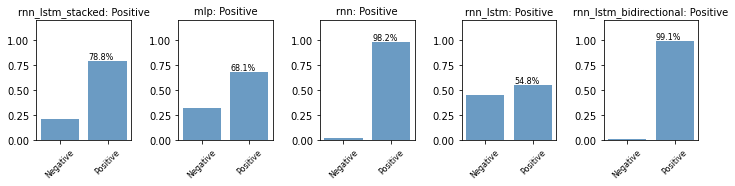

........................................ Negative ........................................
As far as Asian horror goes, I have seen my share of disappointments along with some of the creepiest sh*t imaginable... "Acacia" doesn't really qualify for either of those categories. It had a few moments of tension and was interesting to watch, yet I couldn't help think that there should have been a tad more to this story. The film deals with a childless couple who decide to adopt a kid who appears to have a fascination with trees. He develops a bond with the Acacia tree in their yard and seems to communicate with it. Then, during a fight with his mother involving their new birth child, he storms off after threatening to find his dead mother who is now a tree. When he doesn't come back, the parents send file a report and wait, while the neighbor girl believes he somehow inhabits the Acacia tree. The pacing is rather slow and the ending gets a bit weird, but I have to recommend this as a slightl

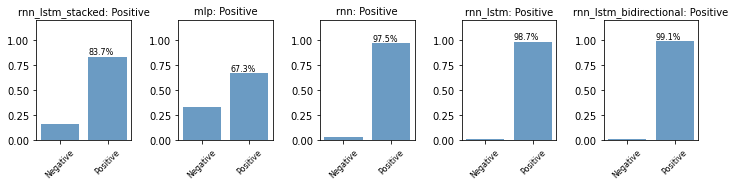

........................................ Positive ........................................
A widely unknown strange little western with mindblowing colours (probably the same material as it was used in "Johnny Guitar", I guess "Trucolor" or something, which makes blood drips look like shining rubies), nearly surrealistic scenes with twisted action and characters. Something different, far from being a masterpiece, but there should be paid more attention to this little gem in western encyclopedias.


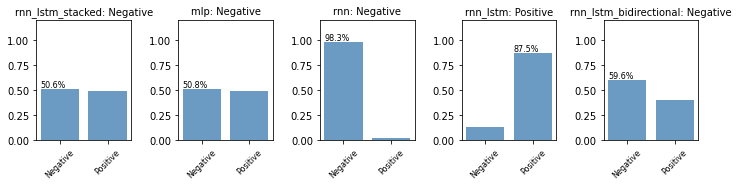

........................................ Positive ........................................
it was a very well written movie, and the actors had a very exquisite way of portraying all the character. but as the movie came to an end i felt as if there was more but they forgot to put it on the dvd. maybe they are planning on making a sequel...well even if they don't it's a good movie and a good rental, but even a better purchase.


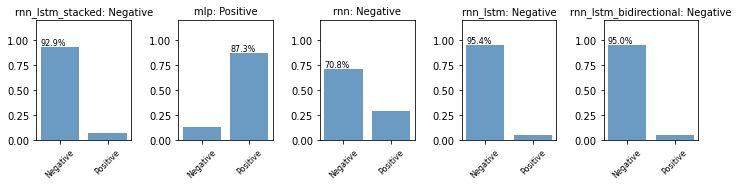

........................................ Positive ........................................
I did enjoy watching Squire Trelane jerk around the crew in this episode, though after a while the whole thing just seemed a little too long. Sure, the histrionics were kind of funny for a while, and the ending was a pretty good way to wrap the whole thing together. I think the problem was that I enjoyed seeing Trelane when he was full of bravado and fun, the fun seemed to vanish when Trelane became vindictive and nasty. Talk about a mood killer--going from the obnoxious but affable host to the guy sentencing Kirk to death! But, despite this, the episode was enjoyable and worth my time. For die-hard Trekkies, this is a must-see, for others it's just a pretty run of the mill one.


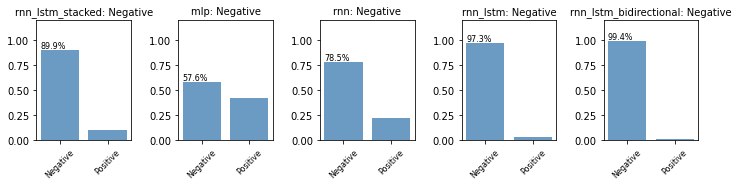

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.079445,0.9948,0.338354,0.8592,5120770,11.0
rnn_lstm,0.003936,0.9992,0.694391,0.8192,2609666,251.0
rnn_lstm_stacked,0.035433,0.9948,0.466913,0.8192,2708482,621.0
rnn_lstm_bidirectional,0.002074,0.9996,0.673339,0.8144,2659202,374.0
rnn,0.001546,1.0000,0.692347,0.7436,2572610,161.0


In [40]:
helper.model_summary(model, history=history)

### sepCNN

In [41]:
def get_sepcnn(helper,
                 blocks=2,
                 filters=64,
                 kernel_size=3,
                 embedding_dim=200,
                 dropout=None,
                 pool_size=3,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None, 
                 name='sepcnn'
                ):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
        
    input_shape = helper.data.input_shape
    num_classes = len(helper.params.classes)
    num_features = helper.params.max_features+1  
    
    model = models.Sequential(name=name)

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0],
                                   weights=[embedding_matrix],
                                   trainable=is_embedding_trainable))
    else:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(layers.Dropout(rate=dropout))
        model.add(layers.SeparableConv1D(filters=filters,
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.SeparableConv1D(filters=filters,     
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.MaxPooling1D(pool_size=pool_size))

    model.add(layers.SeparableConv1D(filters=filters * 2,
                                     kernel_size=kernel_size,
                                     activation='relu',
                                     bias_initializer='random_uniform',
                                     depthwise_initializer='random_uniform',
                                     padding='same'))
    model.add(layers.SeparableConv1D(filters=filters * 2,
                                     kernel_size=kernel_size,
                                     activation='relu',
                                     bias_initializer='random_uniform',
                                     depthwise_initializer='random_uniform',
                                     padding='same'))
    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(2))
    helper.compile(model)  
    return model

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_sepcnn(helper)
model.summary()

model_params.sepcnn.dropout=0.3
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/sepcnn/checkpoint
Model: "sepcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 500, 200)          0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 500, 64)           13464     
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 500, 64)           4352      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 166, 64)           0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 166, 128)          8512      
_____________________

2021-01-04 07:31:30,713: INFO: start training


model_params.sepcnn.epochs=20
use ModelCheckpoint(filepath=./checkpoints/imdb/sepcnn/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/20
78/78 [==============================] - 3s 35ms/step - loss: 0.6941 - accuracy: 0.4792 - val_loss: 0.6933 - val_accuracy: 0.4852
Epoch 2/20
78/78 [==============================] - 2s 31ms/step - loss: 0.6936 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.4852
Epoch 3/20
78/78 [==============================] - 3s 33ms/step - loss: 0.6932 - accuracy: 0.5032 - val_loss: 0.6929 - val_accuracy: 0.5148
Epoch 4/20
78/78 [==============================] - 2s 31ms/step - loss: 0.6934 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.4852
Epoch 5/20
78/78 [==============================] - 2s 32ms/step - loss: 0.6937 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.4852
Epoch 6/20
78/

2021-01-04 07:32:22,224: INFO: finish training [elapsed time: 51.51 seconds]


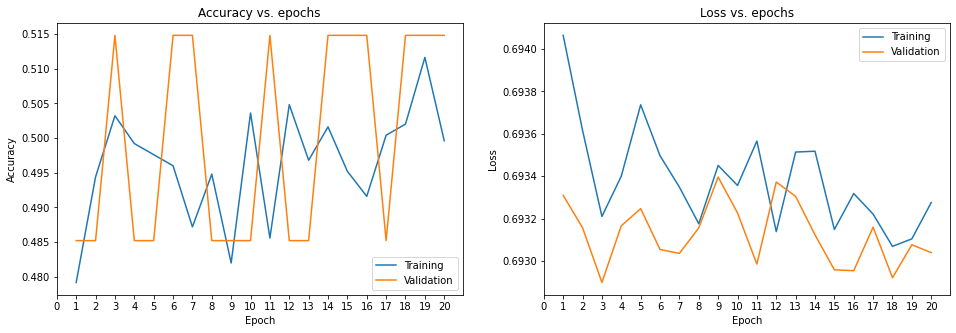

In [42]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
79/79 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5148
Test loss:0.6929, Test Accuracy:51.48%
---------------------------------------- confusion matrix ----------------------------------------
79/79 [==============================] - 0s 4ms/step


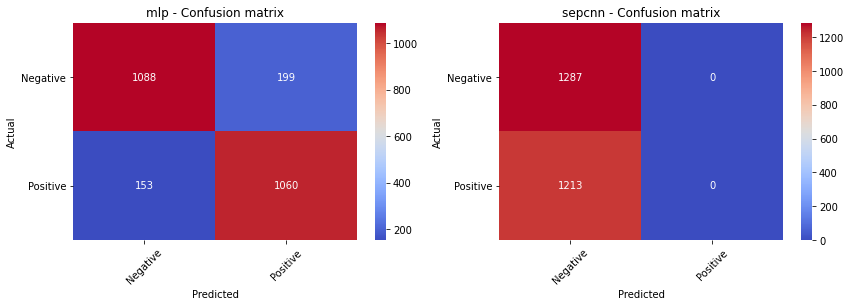

---------------------------------------- error analysis ----------------------------------------
79/79 [==============================] - 0s 4ms/step
........................................ Positive ........................................
Definitely worth watching.<br /><br />Ten different directors each present a segment based on their favorite opera aria. You don't need to be an opera lover to watch this film. (Although, of course, if you hate opera, you're really going to have a bad time with this!)<br /><br />Not surprisingly the segments range from brilliant to only fair. Most of the fuss seems to be over Godard's contribution -- whether you think he's brilliant or pretentious, his segment won't change your mind.<br /><br />Some of the pieces have a clear narrative; others are more a montage of connected images.<br /><br />None of the pieces is more than 10 minutes or so; if you're not happy with what's on the screen, wait for the next segment, and think about how much culture y

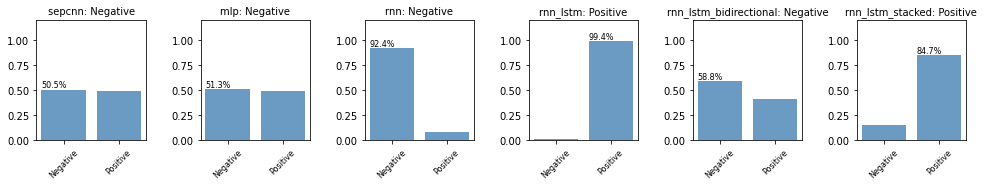

........................................ Positive ........................................
This is probably the best movie from director Hector Babenco. It shows a Brazilian reality unknown by foreigners, which is the same reality that haunts all of the Latin American countries, poverty and a survival instinct. The most affected in this reality is the children usually left orphans, or abandoned by their poor parents have to make it in a "dog eat dog" society many times falling into the gap of delinquency, prostitution and crime. Very well acted and with a "no frills" approach, this movie will get to you, Great story plot, a must have movie on anybody's collection. The starring role went to Fernando Ramos da Silva, a young boy who fell into the crime wave, killed some years later during a robbery. I would suggest people to watch the movie "Who killed Pixote?" so you can have a more in depth idea of the lives of these characters. Some other Characters from the movie had a similar fate, s

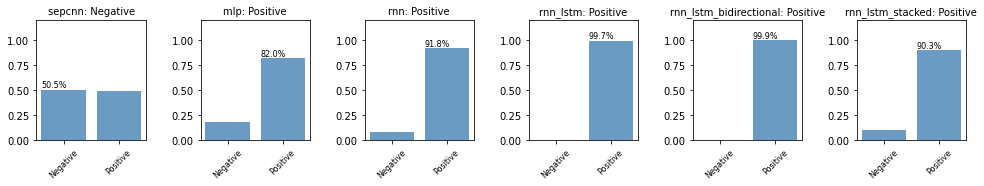

........................................ Positive ........................................
I bought the DVD a long time ago and finally got around to watching it.I really enjoyed watching this film as you don't get the chance to see many of the more serious better quality bollywood films like this. Very well done and but I would say you need to pay attention to what is going on as it is easy to get lost. When you start watching the movie, don't do anything else! I would actually advise people to read all the reviews here...including the ones with spoilers, before watching the movie. Raima Sen gave her first great performance that I have seen. Aishwarya was easily at her best. All performances were strong, directing and cinematography...go watch it!


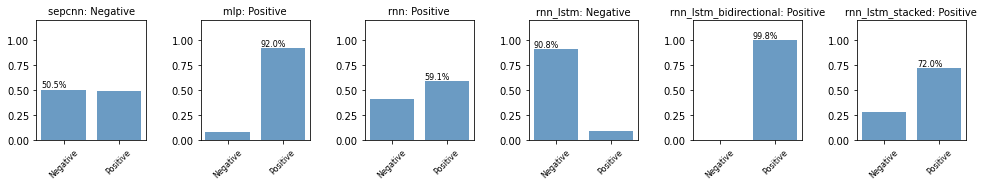

........................................ Positive ........................................
One of the finest movies I have viewed...Good script, original plot of a man who is haunted about JFK's assassination when he was assigned to protect him on that Cold November day in 1963. Thirty years later another anti-social lunatic wants to assassinate the current president. The secret service agent loses his partner along the way,to the crazed gunmen who schemes,lies and murders anybody in his path who'll stand in his way of his mission. <br /><br />The movie accompanies with a great memorable score,and a restrained but meaningful romance between Russo and Eastwood....which displays how difficult it is to have a romantic life in that kind of work. Malchovich is great,sure many other candidates could have played the role that he played,but how many could acted with such craftiness,and intellect that he displayed in the movie?<br /><br />Needless to say,I thought this was a great movie...every

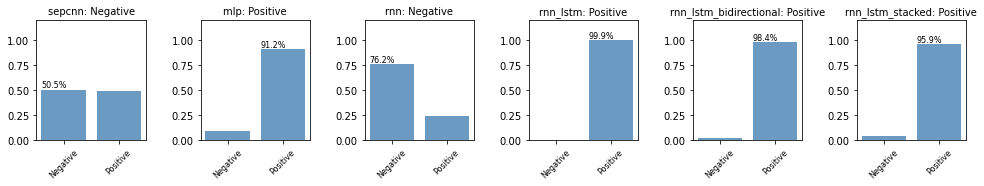

........................................ Positive ........................................
Like most sports movies, it's not surprising that people who know something about the sport can find flaws in it. As a soccer referee, I have yet to see a movie or TV show get it right when depicting a match. "Forever" has good actors, but I found Sean Astin to be a bit young to be an administrator in a juvenile jail. I was very thankful that the plot did not involve the lead character turning his fellow inmates into rugby players and taking on Flagstaff as well as Highland. Which gets to credulity: a police squad car just happens to pull up at precisely the time the Flagstaff baddies are hazing Rick Penning. Even though rugby is not a sanctioned high school sport nationally, the team is a school-based club sport -- much like rodeo. That said, I find it hard to believe that high school officials would allow students to play with open wounds: That just isn't done in this day of AIDS and Hepatitis.

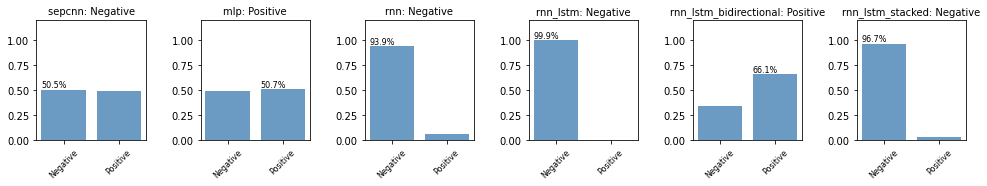

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.079445,0.9948,0.338354,0.8592,5120770,11.0
rnn_lstm,0.003936,0.9992,0.694391,0.8192,2609666,251.0
rnn_lstm_stacked,0.035433,0.9948,0.466913,0.8192,2708482,621.0
rnn_lstm_bidirectional,0.002074,0.9996,0.673339,0.8144,2659202,374.0
rnn,0.001546,1.0000,0.692347,0.7436,2572610,161.0
sepcnn,0.693198,0.5000,0.692900,0.5148,4043682,51.0


In [46]:
helper.model_summary(model, history=history)

![image-20201217163929440](images/image-20201217163929440.png)